# Part 1: Genres and communities and plotting 

<div style="border: 1px solid white; padding: 10px;">

The questions below are based on Lecture 7, part 2.

* Write about genres and modularity.
* Detect the communities, discuss the value of modularity in comparison to the genres.
* Calculate the matrix $D$ and discuss your findings.
* Plot the communities and comment on your results.

</div>

<font color='skyblue'>Answer 1 Part 1: **Write about genres and modularity**</font>

Modularity is a measure that quantifies the quality of a particular partition of a network into communities, aiming to capture the strenght of connections within each community compared to what would be expected by random chance. It assesses whether nodes within the same community are more dansely connected to each other than to nodes in other comminities.

In a network with $N$ nodes and $L$ links, modularity $M$ for a given partition into $n_c$ communities is calculated by comparing the actual number of links within each community $C_c$ to the number we would expect if the network were randomly structured (while perserving each node's total degree or connectivity). For each community $C_c$ mosularity is defined as:

$$M_c = \frac{L_c}{L} - (\frac{K_c}{2L})^2$$


A higher modularity means a stronger community structure, where nodes within each community are more densely connected to each other than to nodes outside the community.

A zero modularity means that the martition has no community structure and a negative modularity would mean that the partitioned structure actually has fewer connection within each community than expected by chance.


<font color='skyblue'>Answer 2 Part 1: **Detect the communities, discuss the value of modularity in comparison to the genres**</font>

*Needed code to load the network: We make all the imports and we create the graph of the wiki artists as in Assigment 1.*

In [1]:
import os
import re
import json
import requests
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
import community.community_louvain as community_louvain
from fa2_modified import ForceAtlas2


In [3]:
# Directory containing Wikipedia pages
SAVE_DIR = "country_artists_wiki"
#SAVE_DIR = "C:/Users/nerea/Documents/MasterDTU/SocialGraphs_fall24/Projects/socialGraphs_fall24/country_artists_wiki"

# Sample list of performers
performers = [file.replace('_', ' ').replace('.txt', '') for file in os.listdir(SAVE_DIR) if file.endswith('.txt')]

# Initialize the directed graph
G = nx.DiGraph()

# Helper function to count words in the page content
def count_words(content):
    words = re.findall(r'\b\w+\b', content)
    return len(words)

# Function to extract valid links pointing to other performers
def extract_links(wikitext, performers):
    # Regular expression to find all Wikipedia links
    links = re.findall(r'\[\[(.*?)(?:\|(.*?))?\]\]', wikitext)
    valid_links = []
    
    for link, display_text in links:
        # Clean the link, replace underscores with spaces, and match against performers
        clean_link = link.replace('_', ' ').strip()
        if clean_link in performers:
            valid_links.append(clean_link)
    
    return valid_links

# Process all performer pages in the directory
for performer_file in os.listdir(SAVE_DIR):
    if performer_file.endswith('.txt'):
        performer_name = performer_file.replace('_', ' ').replace('.txt', '')
        
        # Open and read the wikitext for this performer
        with open(os.path.join(SAVE_DIR, performer_file), 'r', encoding='utf-8') as f:
            wikitext = f.read()
        
        # Extract links to other performers
        linked_performers = extract_links(wikitext, performers)
        
        # Count the number of words in the page content
        word_count = count_words(wikitext)
        
        # Add the node to the graph with the word count as an attribute
        G.add_node(performer_name, word_count=word_count)
        
        # Add directed edges from this performer to the performers they link to
        for linked_performer in linked_performers:
            G.add_edge(performer_name, linked_performer)

# Remove disconnected nodes from the graph
G.remove_nodes_from(list(nx.isolates(G)))

# Remove self-loops from the graph
G.remove_edges_from(nx.selfloop_edges(G))

# Remove multiple edges between the same nodes
G = nx.DiGraph(G)

# Save the graph to a file
nx.write_graphml(G, "country_artists_graph_final.graphml")

# Output the number of nodes and edges
print(f"Total performers (nodes): {G.number_of_nodes()}")
print(f"Total links (edges): {G.number_of_edges()}")

Total performers (nodes): 1952
Total links (edges): 17705


*The network is converted to an undirected network and filtered with the artists that artist_genres.txt contains.*

In [4]:
# Convert the graph to an undirected graph
G_undirected = G.to_undirected()

# Load genre data from URL
url = "https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2024/refs/heads/main/files/artists_genres_dictionary.txt"
response = requests.get(url)
genre_data = json.loads(response.text)

# Extract artist names as a set
artist_names = set(genre_data.keys())

# Create a subgraph that only includes nodes present in artist_names
filtered_G = G_undirected.subgraph([node for node in G_undirected.nodes if node in artist_names])

# Add genre information as a node attribute
for artist in filtered_G.nodes:
    # Assign the genres from genre_data to each artist node
    filtered_G.nodes[artist]['genres'] = genre_data[artist]

# Verify the genre mapping
#print("Filtered graph attributes with genres:", filtered_G.nodes.data())

# Print summary of the filtered graph
print("Filtered graph has", filtered_G.number_of_nodes(), "nodes and", filtered_G.number_of_edges(), "edges.")

Filtered graph has 1828 nodes and 14087 edges.


*The first partition taking into account the first genre of each artist is done.*

In [17]:
# Create a partition based on the first genre attribute
partition_genre = {}
for node in filtered_G.nodes:
    first_genre = filtered_G.nodes[node]['genres'][0]  # Get the first genre of the artist
    if first_genre not in partition_genre:
        partition_genre[first_genre] = set()  # Initialize the genre set
    partition_genre[first_genre].add(node)  # Add the artist to the genre set

# Display the partition structure
for genre, nodes in partition_genre.items():
    print(f"{genre}: {len(nodes)} nodes")

country: 1218 nodes
folk: 36 nodes
country rock: 34 nodes
neotraditional country: 12 nodes
alternative metal: 1 nodes
soul: 4 nodes
rock: 44 nodes
tropical rock: 1 nodes
blues: 6 nodes
western swing: 7 nodes
outlaw country: 6 nodes
alternative country: 24 nodes
progressive country: 7 nodes
rock and roll: 14 nodes
pop: 44 nodes
country music: 25 nodes
bluegrass: 51 nodes
old-time: 2 nodes
southern rock: 11 nodes
country pop: 30 nodes
australian country: 1 nodes
jazz: 5 nodes
americana: 50 nodes
country-folk: 1 nodes
soft rock: 3 nodes
progressive bluegrass: 8 nodes
ccm: 3 nodes
texas country: 5 nodes
tejano: 3 nodes
vocal pop: 1 nodes
traditional pop: 5 nodes
rockabilly: 12 nodes
new mexico music: 2 nodes
latin pop: 1 nodes
latin music: 1 nodes
contemporary christian: 3 nodes
folk rock: 5 nodes
roots rock: 5 nodes
alt country: 1 nodes
country folk: 5 nodes
indie pop: 2 nodes
swamp rock: 1 nodes
hard rock: 4 nodes
blue-eyed soul: 2 nodes
neotraditionalist country: 1 nodes
garage rock: 1 

Above are the genre communities based on the first genre of each artist, showing the number of nodes in each community.

As we can already see from the printout, the largest community is based on the country genre, as many artists have this gerne as their first.

In [95]:
# Calculate L (total links) in the entire network
L = filtered_G.number_of_edges()

# Calculate modularity using the formula from chapter 9
modularity_genre = 0
for community in partition_genre.values():
    subgraph = filtered_G.subgraph(community)
    
    # L_c: Count of edges within the community
    L_c = subgraph.number_of_edges()
    
    # k_c: Total degree of the nodes in this community
    k_c = sum(deg for node, deg in subgraph.degree())

    # Calculate modularity contribution for this community 
    # (L_C/L is the fraction of edges within the community, and k_c/(2L) is the expected fraction of edges in a random network)
    modularity_genre += ((L_c / L) - (k_c / (2 * L)) ** 2)

print("Modularity of the genre-based partition (formula book):", modularity_genre)

Modularity of the genre-based partition (formula book): 0.2772722501503544


The modularity score is **low**, meaning **there is that degree of community structure, but it is not particularly strong**.

This might be due to the fact that there are 1,218 nodes categorized as "country," making this genre the largest community by far. As a result, a lot of the edges are likely found within this one group. When communities are large, they can lower the modularity score because the $\left(\frac{k_c}{2L}\right)^2$ value gets really high, which means this cluster's impact on modularity is lessened.

Additionally, several genres that have only one or just a few nodes. These small or single-node communities barely affect the modularity score since they lack internal edges to add to the $L_c$ value. Therefore, their contribution to modularity is minimal, which ultimately decreases the overall modularity of the network.

*A second partition is done taking into account the first genre of each artist that is NOT country.*

In [96]:
# Partition based on the first genre that is not "country"
partition_nocountry = {}
for node in filtered_G.nodes():
    genres = filtered_G.nodes[node]['genres']
    
    # Find the first genre that is not "country" or default to "country" if none found
    first_non_country_genre = next((genre for genre in genres if genre != "country"), "country")
    
    # Create a community for the genre if it doesn't exist and add the node
    if first_non_country_genre not in partition_nocountry:
        partition_nocountry[first_non_country_genre] = set()
    partition_nocountry[first_non_country_genre].add(node)

# Display the partition structure
for genre, nodes in partition_nocountry.items():
    print(f"{genre}: {len(nodes)} nodes")


outlaw country: 23 nodes
ccm: 6 nodes
gospel: 21 nodes
country: 762 nodes
folk: 74 nodes
country rock: 72 nodes
americana: 65 nodes
country pop: 84 nodes
honky-tonk: 9 nodes
neotraditional country: 18 nodes
christian music: 3 nodes
alternative metal: 1 nodes
soul: 6 nodes
rock: 58 nodes
nashville sound: 11 nodes
tropical rock: 1 nodes
blues: 17 nodes
soft rock: 7 nodes
western: 13 nodes
red dirt: 8 nodes
western swing: 13 nodes
alternative country: 30 nodes
progressive country: 14 nodes
rock and roll: 17 nodes
pop: 89 nodes
country music: 25 nodes
and: 2 nodes
bluegrass: 77 nodes
old-time: 3 nodes
southern rock: 20 nodes
easy listening: 1 nodes
rockabilly: 32 nodes
australian country: 1 nodes
jazz: 7 nodes
country-folk: 1 nodes
country folk: 7 nodes
progressive bluegrass: 8 nodes
texas country: 6 nodes
tejano: 3 nodes
southern gospel: 2 nodes
vocal pop: 1 nodes
traditional pop: 6 nodes
new mexico music: 2 nodes
latin pop: 1 nodes
latin music: 1 nodes
christian: 6 nodes
contemporary chr

As can be seen, the 1218 nodes that belonged to country have been distributed to other communities.

In [97]:
# Calculate modularity using Equation 9.12 with this new partition
L = filtered_G.number_of_edges()
modularity_nocountry = 0
for community in partition_nocountry.values():
    subgraph = filtered_G.subgraph(community)
    
    # L_c: Count of edges within the community
    L_c = subgraph.number_of_edges()
    
    # k_c: Sum of degrees of nodes in the community
    k_c = sum(deg for node, deg in subgraph.degree())
    
    # Calculate modularity contribution for this community
    modularity_nocountry += ((L_c / L) - (k_c / (2 * L)) ** 2)

print("Modularity of the non-country genre-based partition (formula book):", modularity_nocountry)

Modularity of the non-country genre-based partition (formula book): 0.17470526675891174


Initially, a significant number of nodes were grouped in the "country" category, forming a big community more or less interconnected. However, **by moving many of these nodes to smaller, specific genres, the network now has a greater number of communities, but each one is less connected internally.**

Breaking the network down by specific genres has also probably increased the number of connections between different communities, since many genres have overlapping influences (like "country rock" and "rock"). These connections between communities further lower the modularity score because modularity is highest when connections are kept within the same community.

Additionally, many of the new communities are quite small, with just one node each, which also contributes to the drop in the modularity score.

*A third partition is done using Louvain method.*

In [25]:
# Compute the Louvain partition
partition_louvain = community_louvain.best_partition(filtered_G)

# Calculate modularity for the Louvain partition
modularity_louvain = community_louvain.modularity(partition_louvain, filtered_G)
print("Modularity of Louvain partition:", modularity_louvain)

# Group nodes by their assigned community
community_groups = defaultdict(list)
for node, community in partition_louvain.items():
    community_groups[community].append(node)

# Print each community and the number of nodes in it
for community_id, nodes in community_groups.items():
    print(f"Community {community_id}: {len(nodes)} nodes")

Modularity of Louvain partition: 0.3889011590997943
Community 0: 444 nodes
Community 1: 265 nodes
Community 2: 546 nodes
Community 3: 439 nodes
Community 4: 33 nodes
Community 6: 58 nodes
Community 7: 39 nodes
Community 8: 2 nodes
Community 9: 1 nodes
Community 5: 1 nodes


Louvain modularity (0.39) is higher than the genre-based modularity (0.28) because it detects communities based on actual connections, rather than genre labels, creating communities with denser internal connectivity and fewer inter-community edges.

<font color='skyblue'>Answer 3 Part 1: **Calculate the matrix $D$ and discuss your findings**</font>

In [99]:
# Get the 7 most common genres
most_common_genres = sorted(partition_genre.keys(), key=lambda g: len(partition_genre[g]), reverse=True)[:7]

# Get 7 biggest communities
community_count = pd.Series(partition_louvain).value_counts()
most_common_communities = community_count.nlargest(7).index.tolist()

# Confusion matrix
D = np.zeros((len(most_common_genres), len(most_common_communities)), dtype=int)

for node in filtered_G.nodes():
    # Get the genres directly from the node attributes
    node_genres = filtered_G.nodes[node]['genres']  # List of genres for the node
    node_community = partition_louvain[node]  # Community ID for the node
    
    # Check if the community is one of the largest ones
    if node_community in most_common_communities:
        community_index = most_common_communities.index(node_community)
        
        # Count all genres of this node
        for genre in node_genres:
            if genre in most_common_genres:
                genre_index = most_common_genres.index(genre)
                D[genre_index, community_index] += 1  # Increment the count in the matrix

# Display the confusion matrix
D_df = pd.DataFrame(D, index=most_common_genres, columns=most_common_communities)
print("Confusion Matrix (Genres vs Communities):")
print(D_df)


Confusion Matrix (Genres vs Communities):
                1    3    0    2   6   4   5
country       436  297  369  327  28  15  18
bluegrass      23   87    9    8   0   0   0
americana       9  104   19   13   6   3   1
rock           16   59   15   20   1   3   2
pop            13   44   50   47   1   1   1
folk            8  124   32    8   0   5   1
country rock   35   55   24   45   7   0   3


Each cell of the confusion matrix represents the count of nodes with a specific genre in a particular community.

The country genre stands out with the highest numbers in various communities, showing its strong influence in the network, especially in community 1, which has 436 nodes. Following this, bluegrass, Americana, rock, folk, and country rock show notable counts in community 3, suggesting potential similarities among these genres. This also highlights a disparity between genre classifications and community divisions, as many artists from different genres are grouped within the same Louvain community.

These findings illustrate the complexity of genre relationships within the music network. The overlap among different genres within the same communities suggests that genre classifications alone may not fully explain the complex connections between artists.

<font color='skyblue'>Answer 4 Part 1: **Plot the communities and comment on your results**</font>

100%|██████████| 1000/1000 [00:36<00:00, 27.53it/s]
C:\Users\nerea\AppData\Local\Temp\ipykernel_18864\813826955.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(largest_communities) + 1)


BarnesHut Approximation  took  7.19  seconds
Repulsion forces  took  27.81  seconds
Gravitational forces  took  0.17  seconds
Attraction forces  took  0.11  seconds
AdjustSpeedAndApplyForces step  took  0.31  seconds


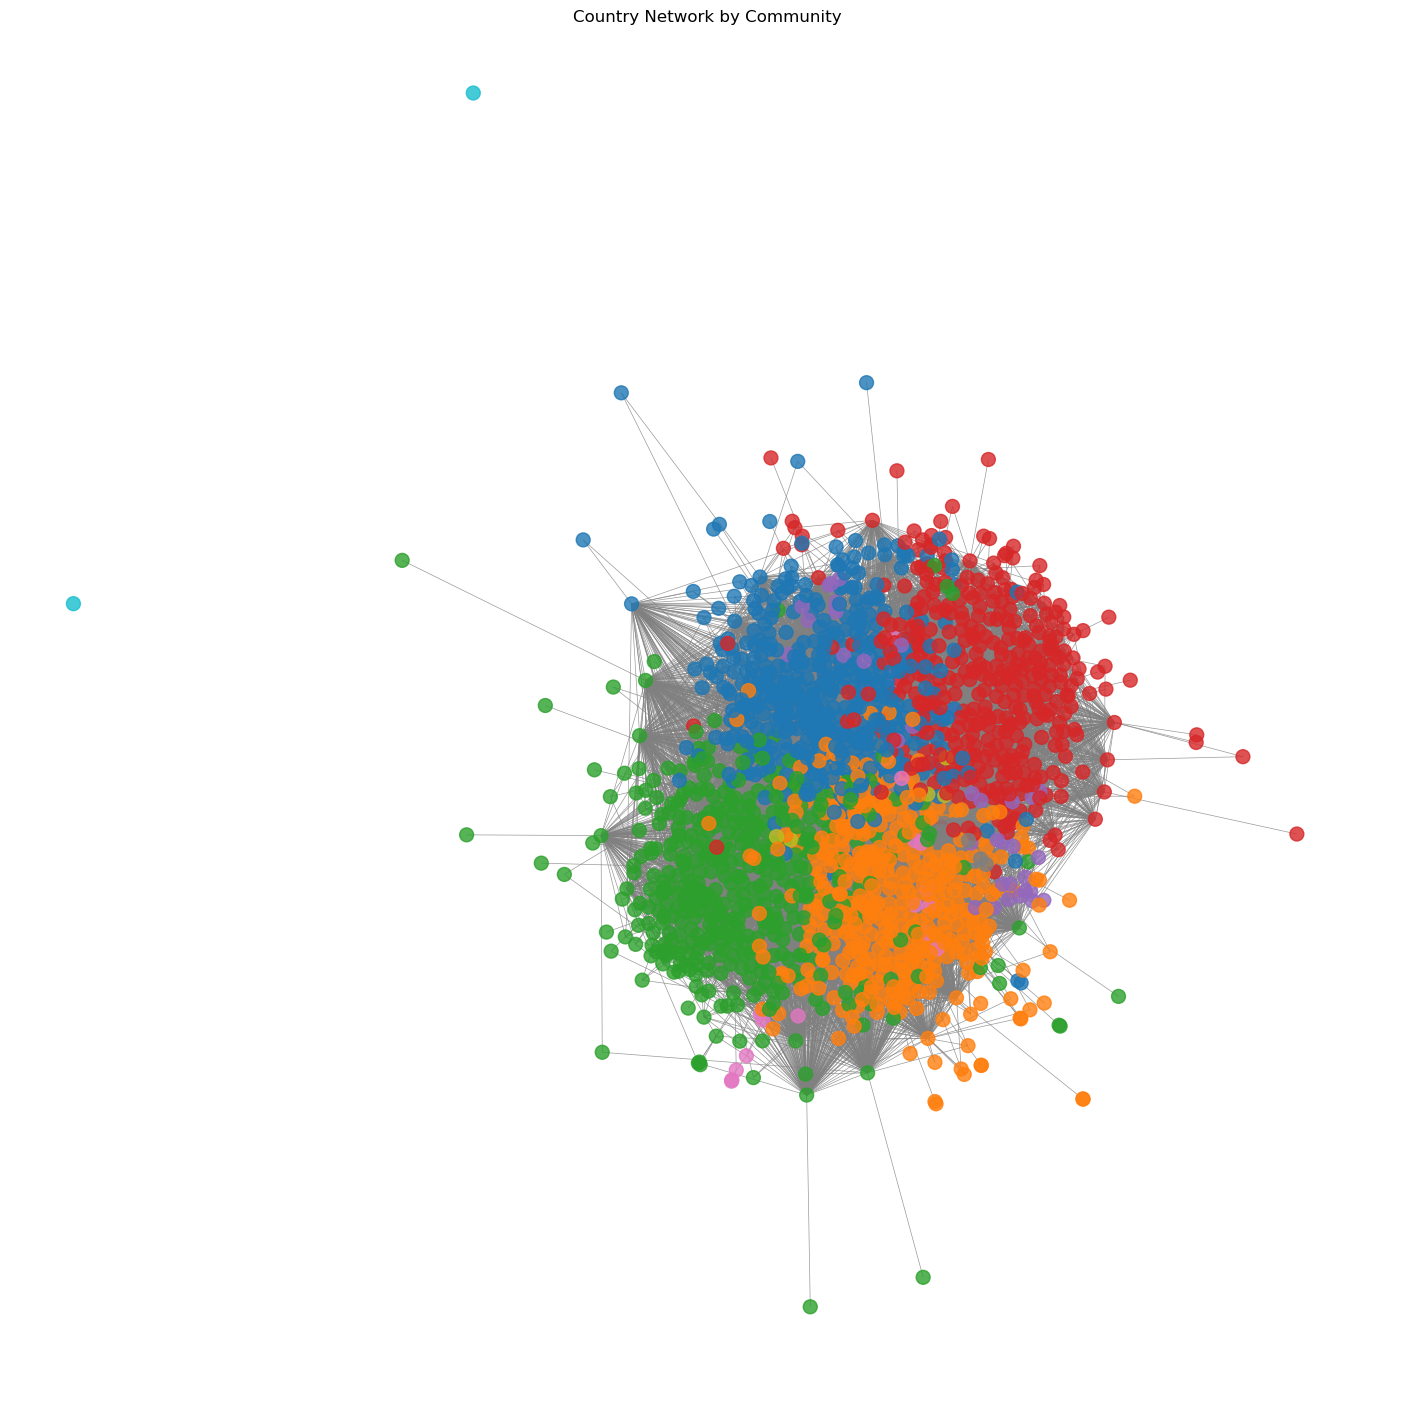

In [100]:
# Select the 10 largest communities
largest_communities = sorted(community_groups.items(), key=lambda x: len(x[1]), reverse=True)[:10]
community_colors = {comm_id: idx for idx, (comm_id, _) in enumerate(largest_communities)}

# Assign colors based on community ID
node_colors = []
for node in filtered_G.nodes():
    comm_id = partition_louvain[node]  # Get community ID for the node
    if comm_id in community_colors:
        node_colors.append(community_colors[comm_id])
    else:
        node_colors.append(-1)  # Assign a neutral color for smaller communities

# Use ForceAtlas2 to get the positions
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,
    scalingRatio=20.0,
    strongGravityMode=False,
    gravity=200,
    verbose=True
)

# Get the positions using ForceAtlas2
positions = forceatlas2.forceatlas2_networkx_layout(filtered_G, iterations=1000)

# Define the color map
cmap = cm.get_cmap('tab10', len(largest_communities) + 1)

# Create the figure
plt.figure(figsize=(18, 18))

# Draw the nodes with colors based on community
nodes = nx.draw_networkx_nodes(
    filtered_G,
    pos=positions,
    node_color=node_colors,
    node_size=100, 
    cmap=cmap,
    alpha=0.8
)

# Draw the edges
edges = nx.draw_networkx_edges(
    filtered_G,
    pos=positions, 
    width=0.5,
    edge_color='gray',
    alpha=0.8
)

# Add a color bar to indicate community IDs
#plt.colorbar(nodes, label="Community ID", ticks=list(range(len(largest_communities) + 1)), boundaries=list(range(len(largest_communities) + 1)))
plt.title('Country Network by Community')

# Show the plot
plt.axis('off')
plt.show()


*Figure 1. Visualization of the country artist network categorized by Louvain communities. Each color represents one of the ten largest communities identified within the network.*

The network is structured around a main core made up of various interconnected clusters, with each color probably indicating a different type of music genre. Although these clusters do overlap, they generally maintain their own specific areas, highlighting that while genres have their own identities, they also have some shared characteristics. Around this central core, there are smaller groups that are loosely connected and some isolated nodes, which could symbolize unique musicians. The differences in the sizes of the clusters imply that certain genres have a larger number of artists compared to others.

# Part 2: TF-IDF to understand genres and communities 

<div style="border: 1px solid white; padding: 10px;">

The questions below  are based on Lecture 7, part 2, 4, 5, 6 (and a little bit on part 3).

* Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
* Calculate and visualize TF-IDF for the genres and communities.
* Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.

</div>

<font color='skyblue'>Answer 1 Part 2: **Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities**</font>

The Term Frequency - Inverse Document Frequency is a widely used statistical method in natural language processing (NPL) that reflects the significance of a word within a document relative to a collection of doucments, known as corpus. The main idea is to quantify the importance of a term in a document with respect to its frequency in the document and its rarity across multiple documents.

TF-IDF scores a word by multiplying the word's Term Frequency (TF) with the Inverse Document Frequency (IDF).

The TF measures how frequently a word appears in a document. It is often calculated as the ratio of the number of occurrences of the term in the document to the total number of words in that document.

The IDF reflects the rarity or uniqueness of the term across the corpus. It assigns higher scores to words that appear in fewer documents, indicating their specificity. The IDF is often calculated as the logarithm of the total number of documents divided by the number of documents containing the term.

In text analysis this metric is useful because it helps to filter out commonly used word that provide little unique information asn intead focuses on words that are more important within specific documents. Words that appear frequently in a single document but rarely in others will have high TF-IDF scores, suggesting they carry important or unique information about the document’s content. Whereas words that are common across many documents will have lower scores, as they are less informative.



<font color='skyblue'>Answer 2 Part 2: **Calculate and visualize TF-IDF for the genres and communities**</font>

In [101]:
import re
import math
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Ensure necessary NLTK resources are downloaded
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nerea\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

*A dictionary based on the genres is created. In every cell of genre_text variable (dictionary) we will have all the wikipedia artist text that correspond to that genre.*

*All the text are cleaned to extract only the plain and important text.*

In [102]:
# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Initialize dictionary to hold aggregated text for each genre
genre_texts = {}

# Iterate through each artist in filtered_G
for artist, data in filtered_G.nodes(data=True):
    genres = data.get('genres', [])

    # Load and clean text
    with open(f"{SAVE_DIR}/{artist.replace(' ', '_')}.txt", "r", encoding="utf-8") as file:
        text = file.read()

        # Remove Wikipedia templates and markup
        text = re.sub(r"\{\{.*?\}\}", "", text)  # Remove templates like {{BLP refimprove}}
        text = re.sub(r"\[\[.*?\|", "", text)  # Remove links with custom text [[link|text]]
        text = re.sub(r"\]\]", "", text)  # Remove remaining brackets from links
        text = re.sub(r"\[\[|\]\]", "", text)  # Remove any remaining double square brackets
        text = re.sub(r"<.*?>", "", text)  # Remove HTML-like tags (e.g., <ref>)
        text = re.sub(r"\|.*?\n", "\n", text)  # Remove infobox fields
        text = re.sub(r"==+.*?==+", "", text)  # Remove section headers like ==Biography==
        text = re.sub(r"\n+", "\n", text)  # Replace multiple newlines with a single newline

        # Remove specific unwanted words and patterns
        text = re.sub(r"(style|width|height|fontsize|billboard|ref|name)[\w\-\d]*", "", text)  # Remove style tags, ref tags, etc.
        text = re.sub(r"\d+em", "", text)  # Remove occurrences of numbers followed by "em" (e.g., "3em")
        text = re.sub(r"usbr|christbr", "", text)  # Remove artifacts like "usbr" and "christbr"

        # Further clean text by removing non-alphabetic characters and extra spaces
        text = re.sub(r"[^a-zA-Z\s]", " ", text)  # Remove all non-alphabetic characters
        text = text.lower()  # Convert text to lowercase
        text = re.sub(r"\b\w{1,2}\b", "", text)  # Remove very short words (1-2 characters)
        text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespace

        # Remove stop words and lemmatize
        words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
        text = ' '.join(words)

        # Aggregate text for each genre
        for genre in genres:
            if genre not in genre_texts:
                genre_texts[genre] = ""
            genre_texts[genre] += " " + text

# Print genre_texts length
# print("Genre's text length:")
# for genre, text in genre_texts.items():
#     print(f"{genre}: {len(text)}")


In [103]:
# Tokenize the text for each genre
genre_tokens = {genre: word_tokenize(text) for genre, text in genre_texts.items()}

# Count word frequencies for each genre and filter out words appearing less than 5 times
genre_word_counts = {genre: Counter(tokens) for genre, tokens in genre_tokens.items()}
genre_word_counts = {genre: {word: count for word, count in counts.items() if count >= 5} for genre, counts in genre_word_counts.items()}

*A TF list is created for each genre.*

In [104]:
# Generate TF list for the top 15 genres
all_genres = [genre for genres in genre_data.values() for genre in genres]
top_genres = [genre for genre, _ in Counter(all_genres).most_common(15)]
genre_tf = {genre: {word: count for word, count in counts.items()} for genre, counts in genre_word_counts.items() if genre in top_genres}

*The TF is calculated for each word of each genre.*

In [105]:
# log-normalize Tf for all the genres
tf_scores = {}
for genre, word_list in genre_tf.items():
    tf_scores[genre] = {}  # Initialize an empty dictionary for each genre
    for word, count in word_list.items():
        tf_scores[genre][word] = 1 + math.log(count)
        

*The IDF is calculated for each word of each genre.*

In [106]:
# Calculate the inverse document frequency (IDF) for each word

# Total number of genres
N = len(genre_tf) 

# Initialize a Counter to store document frequencies
df_counts = Counter()  

# Calculate document frequency for each word
for genre, word_list in genre_tf.items():
    df_counts.update(word_list.keys())

# Calculate IDF for each word
idf_scores = {}
for word, df in df_counts.items():
    idf_scores[word] = math.log(N / df)

# Print IDF scores for the top 15 genres for verification
# print(f"IDF scores for the top 15 genres:")
# for word, idf in idf_scores.items():
    # print(f"{word}: {idf}")


*The TF-IDF is calculatd for each word of each genre.*

In [107]:
# Calculate TF-IDF scores for each word in each genre
tfidf_scores = {}
for genre, word_list in genre_tf.items():
    tfidf_scores[genre] = {word: tf_scores[genre][word] * idf_scores[word] for word in word_list}

# Print the TF-IDF scores for the top 15 genres
# for genre, scores in tfidf_scores.items():
    # print(f"TF-IDF scores for {genre}:")
    # for word, score in scores.items():
        # print(f"{word}: {score}")
    # print("\n")


*Only the 10 words with higher TF-IDF of each genre are selected.*

In [108]:
# Identify top 10 words based on TF-IDF scores
top_words_tfidf = {}
for genre, scores in tfidf_scores.items():
    # Sort words by TF-IDF score and get the top 10
    top_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]
    top_words_tfidf[genre] = top_words

    # Print the genre and its top words
    # print(f"\nTop 10 words for '{genre}':")
    # for word, score in top_words:
        # print(f"{word}: {score:.4f}")

*The WordCloud for each genre is created and displayed.*

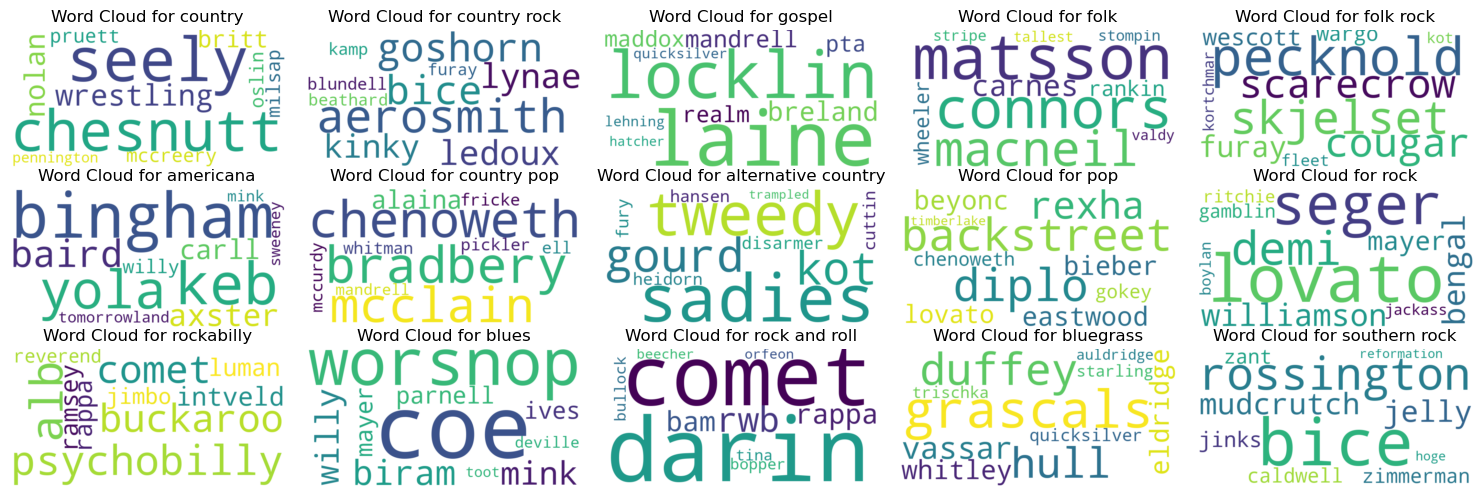

In [109]:
# Number of genres
num_genres = len(top_words_tfidf)

# Determine the number of rows and columns for the subplots
cols = 5
rows = (num_genres + 1) // cols

# Create a figure and a set of subplots
fig, axs = plt.subplots(rows, cols, figsize=(15, 5))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Generate word clouds
for i, (genre, top_words) in enumerate(top_words_tfidf.items()):
    # Prepare a single string with each word repeated according to its TF-IDF score
    wordcloud_input = ' '.join([word for word, score in top_words for _ in range(int(score))])
    
    # Create the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(wordcloud_input)
    
    # Display the word cloud
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].axis('off')
    axs[i].set_title(f"Word Cloud for {genre}")

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

*Figure 2. Word clouds visualizing the top words associated with the top 15 musical genres, with the size of each word corresponding to its TF-IDF score. Higher TF-IDF scores indicate greater importance of the word in distinguishing that genre from others.* 

Given that the metric used was TF-IDF to form the WordClouds, the words that can be seen in the Figure make sense.

As it can be seen, and taking country as an example, the words "Seely", "Chesnutt" and "Wrestling" correspond  to music artits in the genre as Jeanny Seely, Mark Chesnutt or Chad Brock, an American country music that was also a professional wrestler player.

The same way, in pop genre famous nowadays artist names can be seen like "Bieber" (Justin Bieber), "Lovato" (Demi Lovato) or "Beyonc" (Beyoncé).

Thus it can be seen that using TF-IDF the words rated as most important are those that appear several times in the same document without appearing in other documents. So it is likely that the artists that appear are dedicated exclusively to that genre, otherwise their TF-IDF score would not have been so high.

Furthermore, as seen in the example of the word Wrestling in country genre, these words are also explaining coincidences that would be missed if this metric were not used. It is quite unlikely that there are more than two artists who are both wrestling players and famous artists.

*A dictionary based on communities is created. In every cell of community_texts variable (dictionary) we will have all the wikipedia artist text that correspond to that community.*

*All the text are cleaned to extract only the plain and important text.*

In [110]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Do the same process for the communities
community_texts = {}
for community_id, nodes in community_groups.items():
    community_texts[community_id] = ""
    for node in nodes:
        with open(f"{SAVE_DIR}/{node.replace(' ', '_')}.txt", "r", encoding="utf-8") as file:
            text = file.read()
            text = re.sub(r"\{\{.*?\}\}", "", text)  # Remove templates like {{BLP refimprove}}
            text = re.sub(r"\[\[.*?\|", "", text)  # Remove links with custom text [[link|text]]
            text = re.sub(r"\]\]", "", text)  # Remove remaining brackets from links
            text = re.sub(r"\[\[|\]\]", "", text)  # Remove any remaining double square brackets
            text = re.sub(r"<.*?>", "", text)  # Remove HTML-like tags (e.g., <ref>)
            text = re.sub(r"\|.*?\n", "\n", text)  # Remove infobox fields
            text = re.sub(r"==+.*?==+", "", text)  # Remove section headers like ==Biography==
            text = re.sub(r"\n+", "\n", text)  # Replace multiple newlines with a single newline
            text = re.sub(r"(style|width|height|fontsize|billboard|ref|name)[\w\-\d]*", "", text)  # Remove style tags, ref tags, etc.
            text = re.sub(r"\d+em", "", text)  # Remove occurrences of numbers followed by "em" (e.g., "3em")
            text = re.sub(r"usbr|christbr", "", text)  # Remove artifacts like "usbr" and "christbr"
            text = re.sub(r"[^a-zA-Z\s]", " ", text)  # Remove all non-alphabetic characters
            text = text.lower()  # Convert text to lowercase
            text = re.sub(r"\b\w{1,2}\b", "", text)  # Remove very short words (1-2 characters)
            text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespace
            words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
            text = ' '.join(words)
            community_texts[community_id] += " " + text
        
# print("Community's text length:")
# for community, text in community_texts.items():
    # print(f"{community}: {len(text)}")

In [111]:
# Tokenize the text for each community
community_tokens = {community: word_tokenize(text) for community, text in community_texts.items()}
community_word_counts = {community: Counter(tokens) for community, tokens in community_tokens.items()}
community_word_counts = {community: {word: count for word, count in counts.items() if count >= 5} for community, counts in community_word_counts.items()}

*A TF list for each community is created.*

In [112]:
comunity_tf = {community: {word: count for word, count in counts.items()} for community, counts in community_word_counts.items()}

*The TF score for each word of each community is calculated.*

In [113]:
# log-normalize Tf for all the communities
tf_scores = {}
for community, word_list in comunity_tf.items():
    tf_scores[community] = {}  # Initialize an empty dictionary for each community
    for word, count in word_list.items():
        tf_scores[community][word] = 1 + math.log(count)

*The IDF scores and the TF-IDF scores for each word of each community is calculated.*

In [114]:
# Calculate the inverse document frequency (IDF) for each word
N = len(comunity_tf)  # Total number of communities
df_counts = Counter()  # Initialize a Counter to store document frequencies

# Calculate document frequency for each word
for community, word_list in comunity_tf.items():
    df_counts.update(word_list.keys())

# Calculate IDF for each word
idf_scores = {}
for word, df in df_counts.items():
    idf_scores[word] = math.log(N / df)

# Calculate TF-IDF scores for each word in each community
tfidf_scores = {}
for community, word_list in comunity_tf.items():
    tfidf_scores[community] = {word: tf_scores[community][word] * idf_scores[word] for word in word_list}

# Print the TF-IDF scores for the communities
# for community, scores in tfidf_scores.items():
    # print(f"TF-IDF scores for {community}:")
    # for word, score in scores.items():
        # print(f"{word}: {score:.4f}")
    # print("\n")

*The 10 word with higher TF-IDF are selected to form the WordClouds.*

In [115]:
# Identify top 10 words based on TF-IDF scores
top_words_tfidf = {}
for community, scores in tfidf_scores.items():
    # Sort words by TF-IDF score and get the top 10
    top_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]
    top_words_tfidf[community] = top_words

    # Print the community and its top words
    # print(f"\nTop 10 words for Community {community}:")
    # for word, score in top_words:
        # print(f"{word}: {score:.4f}")

*The wordCloud for each community are displayed.*

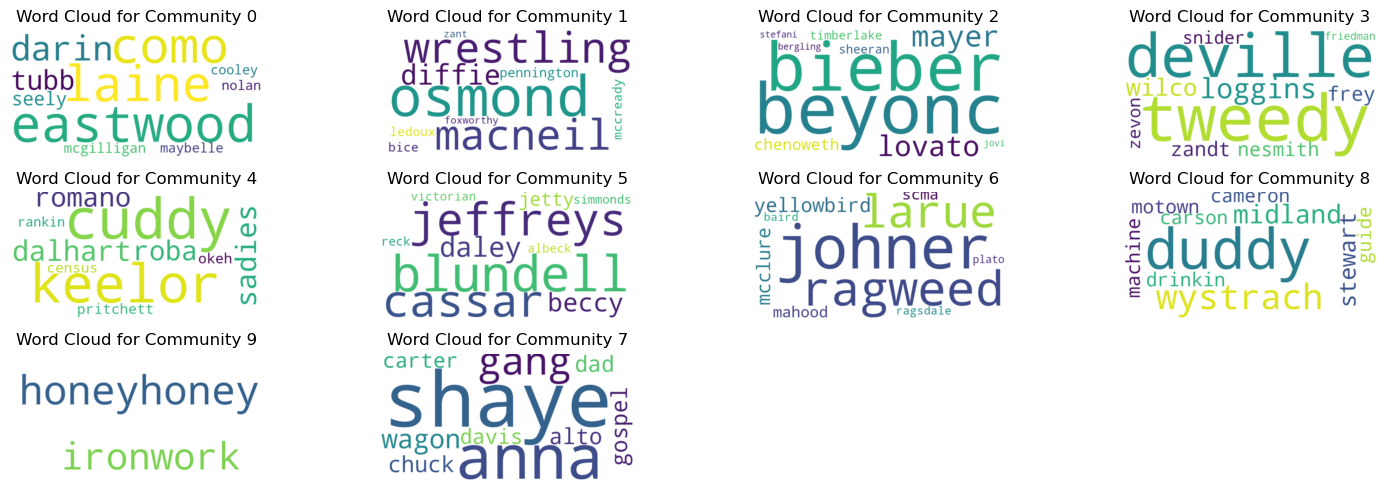

In [120]:
# Display the top words for each community
num_communities = len(top_words_tfidf)
cols = 4
rows = (num_communities + cols - 1) // cols  # Adjust the number of rows to fit all communities
fig, axs = plt.subplots(rows, cols, figsize=(15, 5))  # Adjust the figure size based on the number of rows
axs = axs.flatten()

for i, (community, top_words) in enumerate(top_words_tfidf.items()):
    wordcloud_input = ' '.join([word for word, score in top_words for _ in range(int(score))])
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(wordcloud_input)
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].axis('off')
    axs[i].set_title(f"Word Cloud for Community {community}")

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

*Figure 3. Word clouds visualizing the top words associated with the communities, with the size of each word corresponding to its TF-IDF score. Higher TF-IDF scores indicate greater importance of the word in distinguishing that community from others.* 

In this case we can observe how each community is more related to a specific genre. For example, community 2 is clearly made up of Pop artists, as we can distinguish names such as "Bieber" (Justin Bieber) or "Mayer" (John Mayer).

However, it can be seen that there are some genres present in several communities, such as the country genre:
* Community 1 with "McCready" (Mindy McCready), "Diffie" (Joe Diffie) or "Wrestling" which appears on Chad Brock's page.
* Community 4 with "Cuddy" (Shawn Cuddy) or "Keelor" (Greg Keelor).

In general, we can say that it is much more difficult to distinguish which genre everyone belongs just by looking at the wordCloud. The fact that we are analysing communities means that each community may have artits that belong to different genres.

<font color='skyblue'>Answer 3 Part 2: **Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.**</font>

The first major difference is the clustering approach taken in both cases. The first WordClouds are grouped by genre, which indicates that each wordcloud highlights the most common or influential names and terms within each genre, regardless of the community to which each node in the network belongs.

In contrast, the second wordclouds are organised by community. Each community represents a group of nodes with a strong connection between them but not necessarily belonging to a single genre.

Recovering the D matrix from the previous exercise, it can be seen that it is more similar to the analysis made by communities than by genre. For example, in the community 2 artists who generally belong to Pop stood out.

This is because although there are 369 nodes that are part of country, these words probably also appear in all communities since country is a genre present in practically all of them.

| Genre        | 1   | 3   | 0   | 2   | 6  | 4  | 5  |
|--------------|-----|-----|-----|-----|----|----|----|
| **country**       | 436 | 297 | 369 | 327 | 28 | 15 | 18 |
| **bluegrass**     | 23  | 87  | 9   | 8   | 0  | 0  | 0  |
| **americana**     | 9   | 104 | 19  | 13  | 6  | 3  | 1  |
| **rock**          | 16  | 59  | 15  | 20  | 1  | 3  | 2  |
| **pop**           | 13  | 44  | 50  | 47  | 1  | 1  | 1  |
| **folk**          | 8   | 124 | 32  | 8   | 0  | 5  | 1  |
| **country rock**  | 35  | 55  | 24  | 45  | 7  | 0  | 3  |

Grouping by genre keeps artists and terms primarily within their musical style, without much interaction between distinct genres. Basically we are looking at the rows of the matrix.

Communities allow us to observe the interconnection between genres. Some terms or artists appear in communities where different genres meet, allowing you to see how different styles or figures can connect different communities. In this case we would be looking at the colums of the matrix.

# Part 3: Sentiment of the artists and communities

<div style="border: 1px solid white; padding: 10px;">

The questions below are based on Lecture 8

* Calculate the sentiment of the Artists pages (OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
* Discuss the sentiment of the largest communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?

</div>

In [6]:
import os
import networkx as nx
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Ensure necessary NLTK data files are downloaded
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<font color='skyblue'>Answer 1 Part 3: **Calculate the sentiment of the Artists pages (OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8**</font>

*A function is created to calculate the sentiment of a list of tokens (each Wikipedia page).*

In [7]:
# Function to calculate the sentiment of a list of tokens
def calculate_sentiment(tokens, labmt_dict, artist_name):
    """
    Calculate the sentiment of a list of tokens based on the LabMT word list.

    Parameters:
    tokens (list of str): List of tokens to analyze.
    labmt_dict (dict): Dictionary with words as keys and happiness scores as values.

    Returns:
    average_happiness (float): Average happiness score of the tokens.
    """
    # Filter tokens that are in the LabMT word list
    valid_tokens = [token for token in tokens if token in labmt_dict]
    
    # Calculate the average happiness score
    if valid_tokens:
        happiness_scores = [labmt_dict[token] for token in valid_tokens]
        average_happiness = sum(happiness_scores) / len(happiness_scores)
        return average_happiness
    else:
        print(f"No valid tokens found for artist: {artist_name}")
        return None  # Return None if no valid tokens are found

In [9]:
# Load the LabMT word list
filepath = "Data_Set_S1.txt"
#filepath = "C:/Users/nerea/Documents/MasterDTU/SocialGraphs_fall24/Projects/socialGraphs_fall24/Data_Set_S1.txt"

labmt_dict = {}
with open(filepath, 'r') as file:
    # Skip the header lines
    next(file)
    next(file)
    
    for line in file:
        parts = line.strip().split('\t')
        if len(parts) > 2 and parts[2] != 'happiness_average':
            try:
                word = parts[0]
                happiness_score = float(parts[2])
                labmt_dict[word] = happiness_score
            except ValueError:
                continue

# Path to the folder containing Wikipedia text files
wiki_folder = "country_artists_wiki"
#wiki_folder = "C:/Users/nerea/Documents/MasterDTU/SocialGraphs_fall24/Projects/socialGraphs_fall24/country_artists_wiki"

*The sentiment score is calculated for each artist.*

In [10]:
stop_words = set(stopwords.words('english'))

# Calculate sentiment scores for the network
for node in filtered_G.nodes():
    artist_name = node.replace(" ", "_")
    wiki_file_path = os.path.join(wiki_folder, f"{artist_name}.txt")

    with open(wiki_file_path, 'r') as file:
        text = file.read()
        tokens = word_tokenize(text)
        tokens = [token.lower() for token in tokens] # Convert tokens to lowercase
        tokens = [token for token in tokens if token.isalpha() and token not in stop_words] # Remove non-alphabetic tokens and stopwords
        sentiment_score = calculate_sentiment(tokens, labmt_dict, artist_name)
        filtered_G.nodes[node]['sentiment'] = sentiment_score


No valid tokens found for artist: The_Stonemans


There is one artist that does not contain any of the words in the LabMT list, so we will not take that into account for the statistics.

In [ ]:
# Calculate statistics
sentiment_scores = [data['sentiment'] for _, data in filtered_G.nodes(data=True) if 'sentiment' in data and data['sentiment'] is not None]

average_sentiment = np.mean(sentiment_scores)
median_sentiment = np.median(sentiment_scores)
variance_sentiment = np.var(sentiment_scores)
percentile_25_sentiment = np.percentile(sentiment_scores, 25)
percentile_75_sentiment = np.percentile(sentiment_scores, 75)

# Print statistics
print(f"Average sentiment score: {average_sentiment}")
print(f"Median sentiment score: {median_sentiment}")
print(f"Sentiment score variance: {variance_sentiment}")
print(f"25th percentile sentiment score: {percentile_25_sentiment}")
print(f"75th percentile sentiment score: {percentile_75_sentiment}")

Average sentiment score: 5.871077758057131
Median sentiment score: 5.882613575628007
Sentiment score variance: 0.019768247591262885
25th percentile sentiment score: 5.806785912190963
75th percentile sentiment score: 5.95118625334117


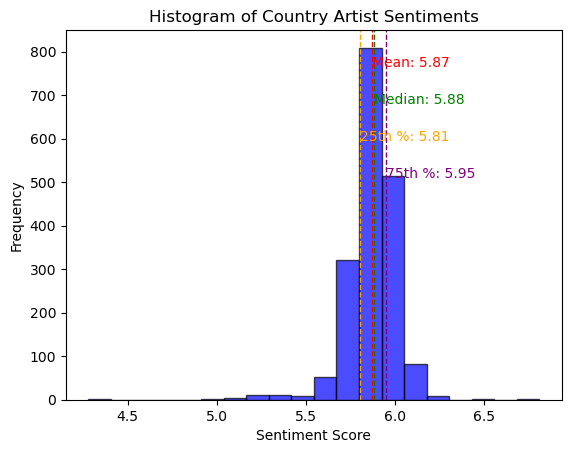

In [12]:
# Plot the histogram of sentiment scores
plt.hist(sentiment_scores, bins=20, alpha=0.7, color='blue', edgecolor='black')

# Add vertical lines for the mean, median, 25th percentile, and 75th percentile    
plt.axvline(average_sentiment, color='red', linestyle='dashed', linewidth=1)
plt.axvline(median_sentiment, color='green', linestyle='dashed', linewidth=1)
plt.axvline(percentile_25_sentiment, color='orange', linestyle='dashed', linewidth=1)
plt.axvline(percentile_75_sentiment, color='purple', linestyle='dashed', linewidth=1)

plt.text(average_sentiment, plt.ylim()[1]*0.9, f"Mean: {average_sentiment:.2f}", color='red')
plt.text(median_sentiment, plt.ylim()[1]*0.8, f"Median: {median_sentiment:.2f}", color='green')
plt.text(percentile_25_sentiment, plt.ylim()[1]*0.7, f"25th %: {percentile_25_sentiment:.2f}", color='orange')
plt.text(percentile_75_sentiment, plt.ylim()[1]*0.6, f"75th %: {percentile_75_sentiment:.2f}", color='purple')

plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Histogram of Country Artist Sentiments')

plt.show()

*Figure 4. Histogram illustrating the distribution of sentiment scores for artist pages. The x-axis represents the sentiment scores, while the y-axis indicates the frequency of scores within specific ranges. Dashed lines denote key statistical metrics: the mean (red), median (green), 25th percentile (orange), and 75th percentile (purple).*

The analysis of the artists' dataset shows a mostly positive emotional tone, with an average sentiment score of about 5.87 and a median of 5.88. This close similarity indicates that the sentiment scores are evenly distributed, meaning that most artists' pages show a positive sentiment. The low variance of 0.02 further supports this, suggesting that the scores are tightly clustered around the average, with minimal differences. The percentiles reveal that half of the sentiment scores are within a small range, further emphasizing the overall positive sentiment.

However, it is crucial to remember that the neutral tone of Wikipedia text, which aims to present unbiased information, might limit the sentiment scores. This neutrality likely plays a role in the generally positive yet moderate sentiment seen in the dataset.

*For further analysis, we identify the top happiest and saddest artists by collecting and sorting their sentiment scores.*

In [16]:
# Collect sentiment scores and corresponding artist names
artist_sentiment = {
    node: data['sentiment']
    for node, data in filtered_G.nodes(data=True) if 'sentiment' in data
}

# Convert to a list of tuples for sorting
sentiment_list = [(artist, score) for artist, score in artist_sentiment.items() if score is not None]

# Sort by sentiment scores (happiest first)
sorted_sentiment = sorted(sentiment_list, key=lambda x: x[1], reverse=True)

# Get the top 10 happiest artists
happiest_artists = sorted_sentiment[:10]

# Get the top 10 saddest artists
saddest_artists = sorted_sentiment[-10:][::-1]

# Display results
print("Top 10 Happiest Artists:")
for artist, score in happiest_artists:
    print(f"{artist}: {score:.3f}")

print("\nTop 10 Saddest Artists:")
for artist, score in saddest_artists:
    print(f"{artist}: {score:.3f}")

Top 10 Happiest Artists:
Flying Burrito Brothers: 6.812
Bacon Brothers: 6.470
Allman Brothers Band: 6.273
The Peasall Sisters: 6.272
Gina Jeffreys: 6.252
Spirit Family Reunion: 6.230
Jasmine Rae: 6.213
Alyssa Micaela: 6.203
Aleyce Simmonds: 6.202
Susan McCann: 6.185

Top 10 Saddest Artists:
Jimmie Rodgers (country singer): 4.280
Brian Kelley (musician): 4.982
Flatt & Scruggs: 5.093
Foggy Mountain Boys: 5.096
Jason Boland & the Stragglers: 5.120
Joanna Smith: 5.170
Kerry Harvick: 5.203
Riley Green (singer): 5.236
Tim Mensy: 5.240
JJ Cale: 5.250


Several factors can affect an artist's sentiment score, determining whether the words in their wikipage produce positive or negative feelings. Two main aspects that play a role in these scores are:

- Musical Themes: Artists with higher happiness scores, like the Flying Burrito Brothers and the Bacon Brothers, usually focus on themes of joy, celebration, and positivity in their songs. For example, the Flying Burrito Brothers have titles that include words like *hearts, together*, and *Christmas*, which are linked to higher sentiment scores. Similarly, the Bacon Brothers wrote a song titled "The Way We Love," which is frequently mentioned on their Wikipedia page and includes the word love, a term that boosts their sentiment score.

- Personal Life Events: An artist's personal experiences, such as struggles with health, public controversies, or personal tragedies, can lead to more negative sentiment. For instance, Jimmie Rodgers faced many challenges during his childhood and dealt with health issues throughout his life until he passed away. Words related to these experiences, like *war, army, death, last*, and *canceled*, generally have lower happiness scores.

<font color='skyblue'>Answer 2 Part 3: **Discuss the sentiment of the largest communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?**</font>

In [26]:
community_sentiments = defaultdict(list)

# Gather sentiment scores for each community
for node, community_id in partition_louvain.items():
    sentiment = filtered_G.nodes[node].get('sentiment')
    if sentiment is not None:  # Only consider nodes with a valid sentiment score
        community_sentiments[community_id].append(sentiment)

# Calculate average sentiment for each community
average_community_sentiments = {
    community_id: np.mean(sentiments) if sentiments else None
    for community_id, sentiments in community_sentiments.items()
}

# Display the average sentiment for each community
for community_id, average_sentiment in average_community_sentiments.items():
    print(f"Community {community_id}: Average Sentiment = {average_sentiment:.2f}" if average_sentiment is not None else f"Community {community_id}: No valid sentiment scores.")

Community 0: Average Sentiment = 5.83
Community 1: Average Sentiment = 5.86
Community 2: Average Sentiment = 5.90
Community 3: Average Sentiment = 5.88
Community 4: Average Sentiment = 5.99
Community 6: Average Sentiment = 5.89
Community 7: Average Sentiment = 5.85
Community 8: Average Sentiment = 6.04
Community 9: Average Sentiment = 5.92
Community 5: Average Sentiment = 5.84


The average sentiment scores for the communities are relatively consistent, ranging from 5.83 to 6.04. This similarity indicates that there is not a significant difference in emotional tone among them, reflecting a general trend of positivity.

There is no clear correlation between the TF-IDF words from each community and their overall sentiment scores. Most TF-IDF words do not appear in the sentiment dictionary, limiting our ability to draw connections between these words and community sentiment. Even "dad," the only word with a significantly positive score, does not notably increase the sentiment score in Community 7. This suggests that while certain words may carry emotional weight, their influence on sentiment may depend more on context than on their isolated emotional scores, resulting in only minor variations in happiness scores across communities.
